In [39]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score

In [40]:
DATASET_DIR = "BreaKHis_v1/histology_slides/breast"
MAGNIFICATIONS = ["40X", "100X", "200X", "400X"]

In [41]:
# Dataset generators
IMG_SIZE = (128, 128)  # Change to (224, 224) for ResNet50
BATCH_SIZE = 32

In [42]:
def load_dataset_structure(dataset_dir):
    """
    Load the dataset structure, accommodating multi-level subfolders.
    Args:
        dataset_dir (str): The path to the dataset directory.
    Returns:
        pd.DataFrame: A DataFrame containing metadata about the dataset.
    """
    data = []
    # Traverse all subdirectories
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg", ".tif")):  # Include valid image formats
                file_path = os.path.join(root, file)
                # Extract class and subtype from folder hierarchy
                class_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
                subtype = os.path.basename(os.path.dirname(file_path))
                data.append({"image_path": file_path, "class": class_name, "subtype": subtype})

    # Convert to DataFrame
    return pd.DataFrame(data)


In [43]:
def load_dataset_structure(dataset_dir):
    data = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Add more extensions if needed
                class_label = os.path.basename(root)  # Parent folder name as class
                file_path = os.path.join(root, file)
                data.append({'file_path': file_path, 'class': class_label})
    return pd.DataFrame(data)

In [44]:
def visualize_class_distribution(dataset_df):
    """
    Visualize the distribution of classes in the dataset.
    Args:
        dataset_df (pd.DataFrame): The dataset DataFrame.
    """
    # Use 'class' instead of 'category'
    class_counts = dataset_df['class'].value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()


In [45]:
def preprocess_and_split(dataset_df, test_size=0.15, val_size=0.15):
    """
    Split the dataset into training, validation, and test sets.
    Args:
        dataset_df (pd.DataFrame): The dataset DataFrame.
        test_size (float): Fraction of data for the test set.
        val_size (float): Fraction of data for the validation set.
    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and testing.
    """
    # Use 'class' instead of 'category'
    train_val_df, test_df = train_test_split(dataset_df, test_size=test_size, stratify=dataset_df['class'], random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=val_size / (1 - test_size), stratify=train_val_df['class'], random_state=42)
    return train_df, val_df, test_df

In [46]:
def create_generators(train_df, val_df, test_df, target_size=(224, 224), batch_size=32):
    """
    Create data generators for training, validation, and testing.
    Args:
        train_df (pd.DataFrame): Training DataFrame.
        val_df (pd.DataFrame): Validation DataFrame.
        test_df (pd.DataFrame): Testing DataFrame.
        target_size (tuple): Target size for image resizing.
        batch_size (int): Batch size for generators.
    Returns:
        train_gen, val_gen, test_gen: Data generators for training, validation, and testing.
    """
    datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',  # Changed from file_path to image_path
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',  # Changed from file_path to image_path
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_gen = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='image_path',  # Changed from file_path to image_path
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_gen, val_gen, test_gen


In [47]:
# Load the dataset
print("Loading dataset structure...")
dataset_df = load_dataset_structure(DATASET_DIR)
if len(dataset_df) == 0:
    print("No images were found in the dataset directory. Please check the directory path.")
else:
    print(f"Loaded {len(dataset_df)} images from the dataset.")


Loading dataset structure...
Loaded 7909 images from the dataset.


Visualizing class distribution...


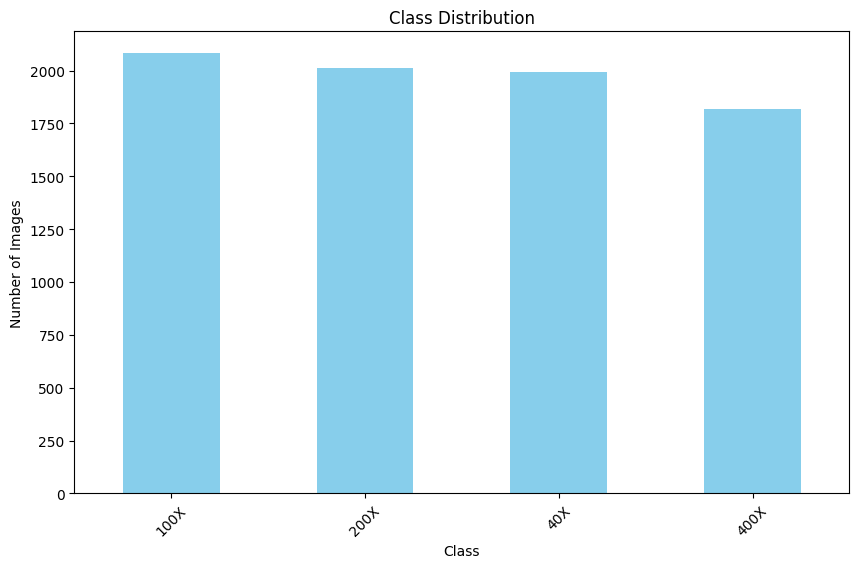

In [48]:
# Visualize class distribution
print("Visualizing class distribution...")
visualize_class_distribution(dataset_df)

In [49]:
# Preprocess and split the dataset
print("Splitting dataset into training, validation, and testing sets...")
train_df, val_df, test_df = preprocess_and_split(dataset_df)
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Testing set: {len(test_df)} images")

Splitting dataset into training, validation, and testing sets...
Training set: 5535 images
Validation set: 1187 images
Testing set: 1187 images


In [50]:
print(f"Columns in train_df: {train_df.columns}")
print(f"Columns in val_df: {val_df.columns}")
print(f"Columns in test_df: {test_df.columns}")

Columns in train_df: Index(['file_path', 'class'], dtype='object')
Columns in val_df: Index(['file_path', 'class'], dtype='object')
Columns in test_df: Index(['file_path', 'class'], dtype='object')


In [51]:
# Rename image_path to file_path
dataset_df.rename(columns={'image_path': 'file_path'}, inplace=True)
train_df.rename(columns={'image_path': 'file_path'}, inplace=True)
val_df.rename(columns={'image_path': 'file_path'}, inplace=True)
test_df.rename(columns={'image_path': 'file_path'}, inplace=True)

# Verify the rename worked
print(f"Columns in train_df: {train_df.columns}")
print(f"Columns in val_df: {val_df.columns}")
print(f"Columns in test_df: {test_df.columns}")


Columns in train_df: Index(['file_path', 'class'], dtype='object')
Columns in val_df: Index(['file_path', 'class'], dtype='object')
Columns in test_df: Index(['file_path', 'class'], dtype='object')


In [52]:
# Debugging: Verify generators
print("Creating data generators...")
try:
    train_gen, val_gen, test_gen = create_generators(train_df, val_df, test_df)
    print("Data generators created successfully.")
except Exception as e:
    print(f"Error in creating data generators: {e}")


Creating data generators...
Error in creating data generators: 'image_path'


In [67]:
def create_generators_from_df(train_df, val_df, test_df):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_path',  # Update to match actual column name
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='file_path',  # Update to match actual column name
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_gen = val_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_path',  # Update to match actual column name
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen


In [54]:
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [55]:
def build_resnet50(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [56]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [61]:
print("Columns in train_df:", train_df.columns)
print("Columns in val_df:", val_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['file_path', 'class'], dtype='object')
Columns in val_df: Index(['file_path', 'class'], dtype='object')
Columns in test_df: Index(['file_path', 'class'], dtype='object')


In [63]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

                                              file_path class
133   BreaKHis_v1/histology_slides/breast\benign\SOB...  100X
6732  BreaKHis_v1/histology_slides/breast\malignant\...  100X
5938  BreaKHis_v1/histology_slides/breast\malignant\...  100X
3993  BreaKHis_v1/histology_slides/breast\malignant\...  200X
254   BreaKHis_v1/histology_slides/breast\benign\SOB...  100X
                                              file_path class
7206  BreaKHis_v1/histology_slides/breast\malignant\...  100X
3568  BreaKHis_v1/histology_slides/breast\malignant\...   40X
6815  BreaKHis_v1/histology_slides/breast\malignant\...   40X
5355  BreaKHis_v1/histology_slides/breast\malignant\...  400X
1809  BreaKHis_v1/histology_slides/breast\benign\SOB...  400X
                                              file_path class
5759  BreaKHis_v1/histology_slides/breast\malignant\...  400X
6501  BreaKHis_v1/histology_slides/breast\malignant\...  200X
3848  BreaKHis_v1/histology_slides/breast\malignant\...   40X
2131  Br

In [68]:
train_gen, val_gen, test_gen = create_generators_from_df(train_df, val_df, test_df)

Found 5535 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.


In [69]:
# Compile and Train CNN
cnn_model = build_cnn((IMG_SIZE[0], IMG_SIZE[1], 3), train_gen.class_indices)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training CNN from scratch...")
history_cnn = cnn_model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

# Evaluate CNN
print("Evaluating CNN...")
cnn_loss, cnn_acc = cnn_model.evaluate(test_gen, verbose=1)
print(f"CNN Test Accuracy: {cnn_acc:.4f}")

AttributeError: 'DataFrameIterator' object has no attribute 'num_classes'

In [ ]:
# Compile and Train ResNet50
resnet50_model = build_resnet50((IMG_SIZE[0], IMG_SIZE[1], 3), train_gen.num_classes)
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training ResNet50 model...")
history_resnet = resnet50_model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

# Fine-tune ResNet50
print("Fine-tuning ResNet50...")
resnet50_model.layers[0].trainable = True  # Unfreeze base model
resnet50_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet_ft = resnet50_model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)

In [ ]:
# Evaluate ResNet50
print("Evaluating ResNet50...")
resnet_loss, resnet_acc = resnet50_model.evaluate(test_gen, verbose=1)
print(f"ResNet50 Test Accuracy: {resnet_acc:.4f}")

# Generate classification report
test_gen.reset()
y_true = test_gen.classes
y_pred_cnn = cnn_model.predict(test_gen)
y_pred_resnet = resnet50_model.predict(test_gen)

print("CNN Classification Report:")
print(classification_report(y_true, y_pred_cnn.argmax(axis=1), target_names=list(test_gen.class_indices.keys())))

print("ResNet50 Classification Report:")
print(classification_report(y_true, y_pred_resnet.argmax(axis=1), target_names=list(test_gen.class_indices.keys())))

# Compute AUC-ROC
print("AUC-ROC Scores:")
cnn_auc = roc_auc_score(y_true, y_pred_cnn, multi_class='ovr')
resnet_auc = roc_auc_score(y_true, y_pred_resnet, multi_class='ovr')
print(f"CNN AUC-ROC: {cnn_auc:.4f}")
print(f"ResNet50 AUC-ROC: {resnet_auc:.4f}")

plot_history(history_cnn, "CNN Training History")
plot_history(history_resnet, "ResNet50 Training History")
plot_history(history_resnet_ft, "ResNet50 Fine-Tuning History")
